# Importing the packages

In [1]:
import numpy as np
import pandas as pd
import pickle

import math
from collections import Counter

# Plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')
# %config InlineBackend.figure_formats = ['svg']
import seaborn as sns

# Used to draw a progress bar for longer method calls
from tqdm import tqdm
tqdm.pandas()

# Pre-trained natural language processing pipeline
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

# Used to import list of punctuations
import string

# Feature extraction (text vectorizers)
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora.dictionary import Dictionary

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Clustering and evaluation
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer


# Topic modeling
from gensim.models import LdaModel
from gensim.models import Nmf
from gensim.models.coherencemodel import CoherenceModel

# Wordcloud
from wordcloud import WordCloud

# Grid search
from sklearn.model_selection import ParameterGrid

# Added Libraries
import re
from collections import Counter

import dash
from dash import dcc, html, Input, Output
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

ModuleNotFoundError: No module named 'spacy'

# Loading the dataset

In [ ]:
df = pd.read_csv('bbc-news-data.csv', sep='\t')
print(df.shape)
df.head(5)

(2225, 4)


,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


# Preprocessing

At first, the text of each article is tokenized, and the preprocessing methods below is done to the text. 
1. Tokenize
2. Lowercase
3. Remove punctuations
4. Remove numbers
5. Remove stop words
6. Lemmatize
7. Remove pronouns
8. Remove short words

In the end, preprocessed text is stores in a new column of dataframe named 'preprocessed_content'.

In [ ]:
# tokenizing
nlp = spacy.load("en_core_web_sm")

def tokenize_text(text):
  doc = nlp(text)
  tokens = [token.text for token in doc]
  return tokens

df['tokens'] = df['content'].apply(tokenize_text)

# lowercasing
df['tokens'] = df['tokens'].apply(lambda tokens: [token.lower() for token in tokens])

# reomving punctuatuins
df['tokens'] = df['tokens'].apply(lambda tokens: [token for token in tokens if token not in string.punctuation])

# removing numbers
df['tokens'] = df['tokens'].apply(lambda x: [token for token in x if token.isalpha()])                                                                                                 

print(df.head())

      category filename                              title  \
0     business  001.txt  Ad sales boost Time Warner profit   
1     business  002.txt   Dollar gains on Greenspan speech   
2     business  003.txt  Yukos unit buyer faces loan claim   
3     business  004.txt  High fuel prices hit BA's profits   
4     business  005.txt  Pernod takeover talk lifts Domecq   
...        ...      ...                                ...   
2220      tech  397.txt   BT program to beat dialler scams   
2221      tech  398.txt    Spam e-mails tempt net shoppers   
2222      tech  399.txt            Be careful how you code   
2223      tech  400.txt    US cyber security chief resigns   
2224      tech  401.txt   Losing yourself in online gaming   

                                                content  \
0      Quarterly profits at US media giant TimeWarne...   
1      The dollar has hit its highest level against ...   
2      The owners of embattled Russian oil giant Yuk...   
3      British Airw

In [ ]:
all_tokens = [token for tokens in df['tokens'] for token in tokens]

token_counts = Counter(all_tokens)

most_common_tokens = [token for token, count in token_counts.most_common(100)]

print(most_common_tokens)

['the', 'to', 'of', 'and', 'a', 'in', 'for', 'is', 'that', 'it', 'on', 'said', 'was', 'he', 'be', 'with', 'has', 'as', 'have', 'at', 'by', 'will', 'but', 'are', 'i', 'not', 'from', 'they', 'his', 'we', 'mr', 'this', 'an', 'would', 'had', 'which', 'been', 'their', 'more', 'year', 'its', 'up', 'were', 'also', 'who', 'people', 'new', 'one', 'there', 'us', 'about', 'can', 'after', 'out', 'or', 'than', 'all', 'could', 'if', 'you', 'm', 'over', 'do', 'last', 'first', 'when', 'time', 'two', 'world', 'government', 'other', 'so', 'now', 'some', 'what', 'into', 'she', 'uk', 'years', 'them', 'best', 'against', 'no', 'only', 'just', 'make', 'being', 'told', 'like', 'get', 'such', 'made', 'game', 'very', 'should', 'film', 'many', 'three', 'back', 'because']


In [ ]:
# removing stop words
most_common_tokens.remove('film')
most_common_tokens.remove('game')
for word in most_common_tokens:
    STOP_WORDS.add(word)

df['tokens'] = df['tokens'].apply(lambda tokens: [token for token in tokens if token not in STOP_WORDS])

# lemmatization
def lemmatizer(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

df["tokens"] = df["tokens"].apply(lemmatizer)

# removing pronouns
common_pronouns = {
    "i", "you", "he", "she", "it", "we", "they",
    "me", "him", "her", "us", "them", "myself",
    "yourself", "himself", "herself", "ourselves",
    "themselves"
}
df["tokens"] = df["tokens"].apply(lambda tokens: [token for token in tokens if token.lower() not in common_pronouns])

# removing shoert tokens
df['tokens'] = df['tokens'].apply(lambda tokens: [token for token in tokens if len(token) >= 3])

# converting tokens to string
df["processed_content"] = df["tokens"].apply(lambda tokens: " ".join(tokens))

df = df.drop(['tokens'], axis=1)
print(df.head())

      category filename                              title  \
0     business  001.txt  Ad sales boost Time Warner profit   
1     business  002.txt   Dollar gains on Greenspan speech   
2     business  003.txt  Yukos unit buyer faces loan claim   
3     business  004.txt  High fuel prices hit BA's profits   
4     business  005.txt  Pernod takeover talk lifts Domecq   
...        ...      ...                                ...   
2220      tech  397.txt   BT program to beat dialler scams   
2221      tech  398.txt    Spam e-mails tempt net shoppers   
2222      tech  399.txt            Be careful how you code   
2223      tech  400.txt    US cyber security chief resigns   
2224      tech  401.txt   Losing yourself in online gaming   

                                                content  \
0      Quarterly profits at US media giant TimeWarne...   
1      The dollar has hit its highest level against ...   
2      The owners of embattled Russian oil giant Yuk...   
3      British Airw

# Feature Extraction from texts

Using TF-IDF vectorization, text features matrix is calculated.

TF-IDF stands for Term Frequency-Inverse Document Frequency. It's a numerical statistic used in text mining and information retrieval to evaluate how important a word is in a document relative to a collection or corpus. The idea is to give higher weights to words that appear frequently in a document but rarely across all documents, making them more useful for distinguishing content.

- Term Frequency (TF): Measures how frequently a term appears in a document.
- Inverse Document Frequency (IDF): Downscales terms that appear in many documents, reducing the weight of common words.

In [ ]:
tf_idf_vectorizer = TfidfVectorizer(max_features=8192)

feature_matrix = tf_idf_vectorizer.fit_transform(df['processed_content'])
feature_names = tf_idf_vectorizer.get_feature_names_out()
tf_idf_df = pd.DataFrame(feature_matrix.toarray(), columns=feature_names)

print(tf_idf_df.shape)
tf_idf_df.iloc[:5, :50]

(2225, 8192)


,aaa,aaas,aaron,abandon,abandonment,abba,abbas,abbasi,abbott,abc,...,accidental,accidentally,acclaim,accolade,accommodate,accommodation,accompany,accomplish,accord,account
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070778
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142117
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000



TF-IDF calculation consists of two parts:

1. Term Frequency (TF):

    This is calculated using the formula $TF = \frac{\text{Frequency of term in doc}}{\text{Number of all terms in doc}}$. This part is essentially a simple count of how often a word appears in a document.

2. Inverse Document Frequency (IDF):

    This part evaluates the importance of a term across all documents. Words that appear in many documents are considered less important, while words that appear in fewer documents are considered more important. Therefore, we calculate this metric using the following formula:

$$IDF = \log(\frac{\text{Total number of documents}}{\text{Number of documents containing the term}})$$

Finally, by multiplying these two metrics, we create the TF-IDF metric, which weights each term based on its importance and its frequency in the document, allowing us to build more meaningful features.

For example, if we have two documents containing the terms "green, green, red" and "green, yellow, yellow," the frequency of the terms would be as follows:
- Document 1: (green = 2), (red = 1)
- Document 2: (green = 1), (yellow = 2)

However, when using TF-IDF, we get:
- Document 1: (green = 0.8), (red = 0.5)
- Document 2: (green = 0.4), (yellow = 0.8)

As you can see, even though the term "red" appears once in Document 1 and "green" appears once in Document 2, the TF-IDF value for "green" in Document 2 is lower. This is because the term "green" appears in both documents, making it less significant.

# Clustering

### Using PCA for dimensionality reduction

In [ ]:
pca = PCA(n_components=0.95)

tf_idf_pca = pca.fit_transform(tf_idf_df)

print(tf_idf_pca.shape)
tf_idf_pca

(2225, 1530)


array([[-0.01363796,  0.14333218,  0.00232292, ..., -0.00273308,
        -0.000607  ,  0.00315087],
       [ 0.06785226,  0.13368315, -0.0581661 , ..., -0.01416598,
         0.00412138,  0.01436447],
       [ 0.03017017,  0.09084908, -0.01639448, ..., -0.01424556,
        -0.00781921, -0.00291879],
       ...,
       [ 0.04247989,  0.07237239,  0.00961798, ...,  0.01195422,
        -0.01041816, -0.01622863],
       [-0.00075645,  0.06793447,  0.00282058, ..., -0.00484351,
        -0.00055637, -0.00557744],
       [-0.11213657, -0.06863049, -0.09076084, ...,  0.01518547,
         0.01291993,  0.01523943]])

<div dir=rtl>
<font face="B Nazanin" size=4>
غالب الگوریتم‌های خوشه‌بندی من‌جمله الگوریتم K-Means، با داده‌های پربعد کارکرد خوبی ندارند و از این جهت کاهش بعد می‌تواند در مقابله با این مشکل به ما کمک کند.
در حد یک یا دو خط در مورد چرایی این موضوع توضیح دهید.
</font>
</p>


<font face="B Nazanin">
<div dir=rtl>
<p align="justify">
<font size=4>
<b> <font color='#eb4034'> توضیحات پاسخ: </font></b>  در داده‌های با بعد بالا، فاصله‌های بردارهای داده به یک‌دیگر نزدیک‌تر می‌شوند. این باعث می‌شود که الگوریتم‌های خوشه‌‌بندی (مثل K-Means) در نتوانند گروه‌بندی‌های معناداری بسازند. زیرا تاثیرگذاری فاصله متریک (فاصله اقلیدوسی) کاهش می‌یابد.<br>
از طرفی ابعاد بیش‌تر باعث افزایش نویز می‌شود، که باعث می‌شود که مدل‌های خوشه‌بندی در دام Overfitting بیوفتند و عملکرد خود را از دست بدهند.
</p>
</font>
</div>
</font>
<hr>

<div dir=rtl>
<font face="B Nazanin" size=4>
با استفاده از الگوریتم خوشه بندی
<code>KMeans</code>
اسناد را خوشه بندی کنید.

برای تعیین بهترین تعداد خوشه‌ها، از معیار Distortion استفاده کنید و Elbow Plot را برای خوشه‌بندی‌ها با K=2 تا K=30 رسم کنید.

در صورتی که از Elbow Plot اطلاعات مفیدی قابل استخراج نبود، خوشه‌بندی‌های گفته شده را با معیار Normalized Mutual Information مقایسه کنید.
</font>
</p>
</div>

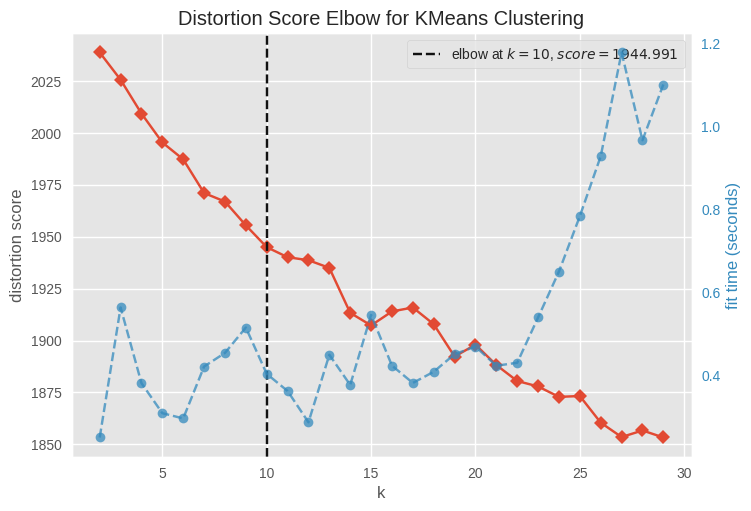

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# TODO - find the optimal number of clusters

KElbowVisualizer(KMeans(), k=(2, 30)).fit(tf_idf_pca).show()

<div dir=rtl>
<font face="B Nazanin" size=4>
پس از انتخاب بهترین تعداد خوشه‌ها، مدل خوشه بندی را با این تعداد آموزش دهید. سپس یک ستون به نام <code>cluster</code> به دیتافریم اضافه کنید که نشان دهنده خوشه‌هایی است که مدل برای هر نمونه پیش بینی کرده است.

</font>
</p>
</div>

In [ ]:
# TODO - KMeans clustering
optimal_k = 9
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

df['cluster'] = kmeans.fit_predict(tf_idf_pca)
print(df)

      category filename                              title  \
0     business  001.txt  Ad sales boost Time Warner profit   
1     business  002.txt   Dollar gains on Greenspan speech   
2     business  003.txt  Yukos unit buyer faces loan claim   
3     business  004.txt  High fuel prices hit BA's profits   
4     business  005.txt  Pernod takeover talk lifts Domecq   
...        ...      ...                                ...   
2220      tech  397.txt   BT program to beat dialler scams   
2221      tech  398.txt    Spam e-mails tempt net shoppers   
2222      tech  399.txt            Be careful how you code   
2223      tech  400.txt    US cyber security chief resigns   
2224      tech  401.txt   Losing yourself in online gaming   

                                                content  \
0      Quarterly profits at US media giant TimeWarne...   
1      The dollar has hit its highest level against ...   
2      The owners of embattled Russian oil giant Yuk...   
3      British Airw

In [ ]:
pickle.dump(df, open("clustered_df.pkl", "wb"))

In [ ]:
df = pickle.load(open("clustered_df.pkl", "rb"))

<div dir=rtl>
<h4>
<font face="B Nazanin">
<b>نمایش خوشه بندی</b>
</font>
</h4>
<div dir=rtl>
<font face="B Nazanin" size=4>
با استفاده از الگوریتم
<code>t-SNE</code>
ابعاد ماتریس ویژگی‌ها را به 2 بعد کاهش دهید و نمودار خوشه بندی را رسم کنید.
</font>
</p>
</div>

In [ ]:
# TODO - TSNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tf_idf_tsne = tsne.fit_transform(tf_idf_df)

print(tf_idf_tsne.shape)
tf_idf_tsne

(2225, 2)


array([[ 22.060556 ,  35.512478 ],
       [ 42.238735 ,  28.816671 ],
       [ 59.97369  ,  35.171627 ],
       ...,
       [  8.36088  ,  14.8484535],
       [ -6.7533035,  47.90914  ],
       [-13.73241  , -10.41366  ]], dtype=float32)

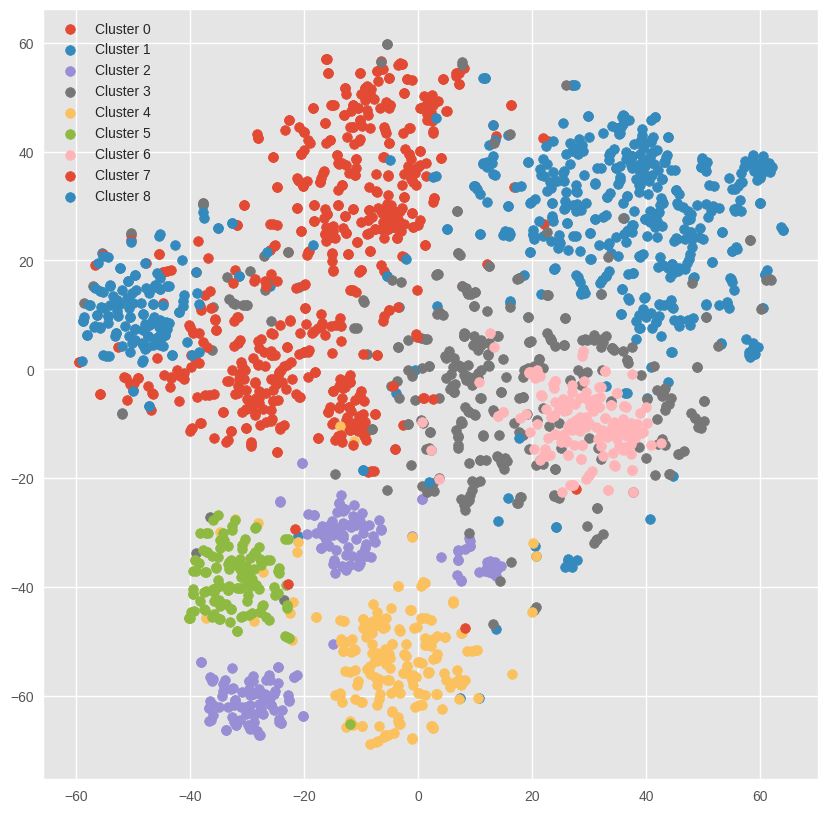

In [ ]:
# TODO - visualize the clusters
plt.figure(figsize=(10, 10))
for i in range(optimal_k):
    plt.scatter(tf_idf_tsne[df['cluster'] == i, 0], tf_idf_tsne[df['cluster'] == i, 1], label=f'Cluster {i}')
plt.legend()
plt.show()

<div dir=rtl>
<font face="B Nazanin" size=4>
در ۴ خط یا کمتر به طور شهودی نحوه‌ی کارکرد الگوریتم t-SNE را توضیح دهید. نیازی به اشاره به علائم و روابط ریاضی نمی‌باشد.
</font>
</p>


<font face="B Nazanin">
<div dir=rtl>
<p align="justify">
<font size=4>
<b> <font color='#eb4034'> توضیحات پاسخ: </font></b>  این الگوریتم در ابتدا با محاسبه شباهت بین هر زوج داده در فضای پربعد، سعی می‌کند تا برای هر نقطه داده، احتمال این‌که یک نقطه دیگر را به‌عنوان همسایه انتخاب کند پیدا کند. این احتمال با استفاده از توزیع نرمال پیدا می‌شود. سپس با با محاسبه احتمال شرطی هر دو نقطه نسبت به یک‌دیگر، احتمال شباهت بین تمام زوج نقطه‌ها را متقارن می‌کند.

حال که این شباهت‌ها را یافتیم، تلاش می‌کنیم داده‌ها را به یک فضای کم‌بعدتر (۲ یا ۳ بعدی) ببریم، بدون آن‌که به داده‌ها آسیب جدی بزنیم. در این مرحله با استفاده از آنتروپی نسبی (Kullback–Leibler (KL) divergence) که معیاری برای اندازه‌گیری میزان واگرایی یک توزیع احتمال نسبت به دیگری است، سعی می‌کنیم این واگرایی را کمینه کنیم.

در این مرحله با استفاده از گرادیان کاهشی (Gradient Descent) به‌صورت تکرارشونده فرایند بهینه‌سازی را انجام می‌دهیم تا در فضای کم‌بعد جدید، فاصله بین نقاط مشابه کمینه و فاصله بین نقاط غیرمشابه بیشینه شود. این الگوریتم به‌صورت تکرارشونده موقعیت نقاط را با استفاده از گرادیان‌های واگرایی KL با توجه به موقعیتشان تغییر می‌دهد. وقتی این فواصل بهینه شوند، کار الگوریتم تمام می‌شود.
</p>
</font>
</div>
</font>
<hr>

<div dir=rtl>
<h2>
<font face="B Nazanin" color="#0099cc">
Topic Modeling

<div dir=rtl>
<font face="B Nazanin" size=4>
در مورد دو الگوریتم استخراج موضوع
<code>Latent Dirichlet Allocation</code> و
<code>Non-Negative Matrix Factorization</code>
مطالعه کرده و به طور خلاصه (بدون نیاز به اشاره به جزئیات ریاضی) نحوه‌ی کارکرد هر یک را توضیح دهید؛
سپس، یکی از این دو الگوریتم را برای ادامهٔ کار انتخاب کنید.
</font>
</p>
</div>

<font face="B Nazanin">
<div dir=rtl>
<p align="justify">
<font size=4>
<b> <font color='#eb4034'> توضیحات پاسخ: </font></b>

الگوریتم LDA:

این الگوریتم با دو فرض راجب سند ها و موضوعات دارد: 1. هر سند ترکیبی از موضوعات است. 2. هر موضوع مجموعه ای از کلمات با توزیع احتمالاتی خاصی است.

هر سند دارای توزیع دیریکله ای (Dirichlet Distribution) از موضوعات است.
هر موضوع دارای توزیع دیریکله ای (Dirichlet Distribution) از کلمات است.
این الگوریتم بدنبال پیدا کردن این توزیع موضوعات و کلمات به کمک اسناد است.

ابتدا الگوریتم به صورت تصادفی به کلمات اسناد موضوعی را نسبت می دهد. سپس الگوریتم بر اساس موضوع های موجود در هر سند و مجموعه کلمات هر موضوع دوباره به هر کلمه موضوعی را نسبت می دهد، این فرآیند بار ها تکرار شده تا اینکه به نتیجه مطلوبی دست پیدا بکند. خروجی این الگوریتم توزیع دیریکله سند ها بر اساس موضوعات است و توزیع دیریکله موضوعات بر اساس کلمات است. یعنی در واقع خروجی این الگوریتم برای هر سند درصد توزیع موضوعات را مشخص میکند و برای هر موضوع مجموعه کلمات با درصد توزیع تخصیص شده به هر موضوع را مشخص میکند.

الگوریتم NMF:

این الگوریتم با ساخت ماتریسی که سطر آن سند ها و ستون آن کلمات است و هر درآیه آن عددی است که این عدد می گوید چقدر آن کلمه به آن سند مربوط و مرتبط است.

این الگوریتم این ماتریس را به دو ماتریس کوچک تر تجزیه می کند، یکی ماتریس وزندار(Weight Matrix) و دیگری ماتریس دیکشنری (Dictionary Matrix).

ماتریس وزندار وزن هر موضوع را با توجه به سند را به ما می دهد. ماتریس دیکشنری به ما مجموعه کلمات در هر موضوع را می دهد.

با ضرب این دو ماتریس، ماتریس اولیه به صورت تقریبی بدست می آید. یعنی هر سند که سطری در ماتریس اولیه است حاصل ضرب سطر وزن های موضوعات بر اساس آن سند در ماتریس وزندار، در ماتریس دیکشنری است یعنی ضرب سطر وزن موضوعات بر اساس سند مورد نظر در خود موضوعات.

نحوه محاسبه هم به این صورت است که اگر ماتریس اولیه به الگوریتم داده شد این الگوریتم به دنبال تجزیه کردن این ماتریس به دو ماتریس توضیح داده شده است به طوری که ضرب این دو ماتریس در هم کمترین اختلاف را با خود ماتریس اولیه داشته باشند یعنی تقریب خوبی از ماتریس اولیه باشند. ابتدا به صورت رندوم دو ماتریس توضیح داده شده ساخته شده سپس به صورت تکرار شونده آن ها را بهتر و دقیق تر کرده تا اینکه به تقریب خوبی برسد.

ما الگوریتم Latent Dirichlet Allocation را انتخاب کردیم.
</p>
</font>
</div>
</font>
<hr>

<div dir=rtl>
<font face="B Nazanin" size=4>
تاپیک مدلینگ را بر روی داده‌های هر خوشه به طور جداگانه باید انجام دهید.
دقت کنید که در استفاده از کتابخانه‌ی <code>gensim</code>، ابتدا باید دیکشنری و BoW (Bag of Words) را برای هر خوشه بسازید.
</font>
</p>
</div>

In [ ]:
# TODO - make Dictionary and Corpus for each cluster

cluster_groups = df.groupby('cluster')['processed_content'].apply(lambda x: [doc.split() for doc in x])
cluster_dictionaries = {cluster: Dictionary(documents) for cluster, documents in cluster_groups.items()}

cluster_dictionaries = {
    cluster: Dictionary(documents) for cluster, documents in cluster_groups.items()
}

cluster_corpora = {
    cluster: [cluster_dictionaries[cluster].doc2bow(doc) for doc in documents]
    for cluster, documents in cluster_groups.items()
}

<div dir=rtl>
<font face="B Nazanin" size=4>
در ادامه باید با بررسی Topic Coherence تحت معیار
<code>C_V</code>،
بهترین تعداد تاپیک‌ها را برای هر خوشه پیدا کنید.
برای هر خوشه مدلی که بیشترین مقدار معیار
را داشت نگه دارید.
<br>
بررسی تعداد تاپیک‌های 5، 10، 15، 20 و 25 کافی می‌باشد.
</font>
</p>
</div>

In [ ]:
# TODO - find the optimal number of topics for each cluster
topic_counts = [5, 10, 15, 20, 25]

best_lda_models = {}
best_coherence_scores = {}

for cluster_num, documents in cluster_groups.items():
    print(f"Processing Cluster {cluster_num}")

    dictionary = cluster_dictionaries[cluster_num]
    corpus = cluster_corpora[cluster_num]

    best_model = None
    highest_score = -1

    for num_topics in topic_counts:
        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10
        )

        coherence_model = CoherenceModel(
            model=lda_model,
            texts=documents,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()

        print(f"Cluster {cluster_num}, Topics: {num_topics}, Coherence: {coherence_score}")

        if coherence_score > highest_score:
            best_model = lda_model
            highest_score = coherence_score

    best_lda_models[cluster_num] = best_model
    best_coherence_scores[cluster_num] = highest_score
    print(f"Best Model for Cluster {cluster_num}: {highest_score}")

print("Best Coherence Scores for Each Cluster:")
for cluster_num, score in best_coherence_scores.items():
    print(f"Cluster {cluster_num}: {score}")

Processing Cluster 0
Cluster 0, Topics: 5, Coherence: 0.3300585973733834
Cluster 0, Topics: 10, Coherence: 0.39357288095158294
Cluster 0, Topics: 15, Coherence: 0.36446251204747165
Cluster 0, Topics: 20, Coherence: 0.3602799511227359
Cluster 0, Topics: 25, Coherence: 0.35175986446580554
Best Model for Cluster 0: 0.39357288095158294
Processing Cluster 1
Cluster 1, Topics: 5, Coherence: 0.3884632969570675
Cluster 1, Topics: 10, Coherence: 0.39450930509604687
Cluster 1, Topics: 15, Coherence: 0.4400157921226909
Cluster 1, Topics: 20, Coherence: 0.38726923011738107
Cluster 1, Topics: 25, Coherence: 0.35448890755252305
Best Model for Cluster 1: 0.4400157921226909
Processing Cluster 2
Cluster 2, Topics: 5, Coherence: 0.597039398632927
Cluster 2, Topics: 10, Coherence: 0.4962487520987803
Cluster 2, Topics: 15, Coherence: 0.478307334849902
Cluster 2, Topics: 20, Coherence: 0.4466590490610323
Cluster 2, Topics: 25, Coherence: 0.45668104479732863
Best Model for Cluster 2: 0.597039398632927
Proce

In [ ]:
for cluster_num, documents in cluster_groups.items():
    scores = []
    for num_topics in topic_counts:
        lda_model = LdaModel(
            corpus=cluster_corpora[cluster_num],
            id2word=cluster_dictionaries[cluster_num],
            num_topics=num_topics,
            random_state=42,
            passes=10
        )
        coherence_model = CoherenceModel(
            model=lda_model,
            texts=documents,
            dictionary=cluster_dictionaries[cluster_num],
            coherence='c_v'
        )
        scores.append(coherence_model.get_coherence())

    plt.plot(topic_counts, scores, marker='o', label=f'Cluster {cluster_num}')

plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Topic Coherence Scores for Each Cluster')
plt.legend()
plt.grid(True)
plt.show()


<div dir=rtl>
<font face="B Nazanin" size=4>
به طور مختصر نحوه‌ی محاسبه‌ی معیار <code>C_V</code> را توضیح دهید.
</font>
</p>


<font face="B Nazanin">
<div dir=rtl>
<p align="justify">
<font size=4>
<b> <font color='#eb4034'> توضیحات پاسخ: </font></b>

این معیار برای ارزیابی کیفیت موضوعات ایجادشده توسط مدل‌هایی مثل LDA است. در این روش ابتدا برای هر موضوع مجموعه‌ای از کلمات کلیدی انتخاب می‌شود. سپس با تبدیل این کلمات به بردارهای عددی، شروع به محاسبه شباهت می‌کنیم. در این بخش با استفاده از معیارهای شباهت مانند شباهت کسینوسی (Cosine Sinilarity)، میزان شباهت بین کلمات در هر موضوع را اندازه‌گیری می‌کنیم. سپس کیفیت موضوع را بر اساس میزان شباهت کلمات آن ارزیابی می‌کنیم.
در نهایت با بررسی هم‌بستگی شباهت بین کلمات یک موضوع، از این نمرات هم‌بستگی میانگین می‌گیریم تا نمای کلی کیفیت مدل را تعیین کنیم.
</p>
</font>
</div>
</font>
<hr>

<div dir=rtl>
<h4>
<font face="B Nazanin">
<b>استخراج کلمات کلیدی تاپیک‌ها</b>
</font>
</h4>
<div dir=rtl>
<font face="B Nazanin" size=4>
در ادامه باید برای هر داده از دیتافریم، 3 تاپیک برتر را که مدل برای آن‌ها پیش بینی کرده است، استخراج کنید. سپس از هر تاپیک 2 کلمه کلیدی با اهمیت را استخرج کنید.
</font>
</p>
</div>

In [ ]:
# TODO - extract keywords for each document
top_keywords_list = []

for i, row in df.iterrows():
    cluster_num = row["cluster"]
    tokens = row["processed_content"].split()

    dictionary = cluster_dictionaries[cluster_num]
    doc_bow = dictionary.doc2bow(tokens)

    doc_topics = best_lda_models[cluster_num].get_document_topics(doc_bow)

    top_three_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)[:3]

    keywords_for_doc = []

    for topic_id, _ in top_three_topics:
        top_terms = best_lda_models[cluster_num].show_topic(topic_id, topn=2)
        keywords_for_doc.extend(term for term, _ in top_terms)

    top_keywords_list.append(keywords_for_doc)

df["top_keywords"] = top_keywords_list

In [ ]:
df

In [ ]:
pickle.dump(df, open("final_df.pkl", "wb"))

In [ ]:
df = pickle.load(open("final_df.pkl", "rb"))

<div dir=rtl>
<h2>
<font face="B Nazanin" color="#0099cc">
نمایش خوشه بندی‌ها و تاپیک‌ها

<div dir=rtl>
<font face="B Nazanin" size=4>
با استفاده از کدی که در ادامه آمده است، می‌توانید نمودار‌های مربوط به خوشه بندی و تاپیک‌ها را مشاهده کنید.
<br>
<font color='#eb4034'>
ساختار دیتا فریمی که به کد زیر داده ‌می‌شود دقیقا باید به صورت زیر باشد:
</font>
</font>
</p>
</div>

<center>
<table style="direction: rtl;align: center; text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <tr>
      <td><code>x</code></td><td>ستون x ماتریس ویژگی‌ها که با TSNE به 2 بعد کاهش یافته است</td>
  </tr>
<tr>
      <td><code>y</code></td><td>ستون y ماتریس ویژگی‌ها که با TSNE به 2 بعد کاهش یافته است</td>
  </tr>
<tr>
      <td><code>cluster</code></td><td>خوشه پیش‌بینی شده برای داده‌ها</td>
  </tr>
<tr>
      <td><code>top_keywords</code></td><td>کلمات کلیدی استخراج شده برای داده‌ها*</td>

</table>
</center>

<div dir=rtl>
<font face="B Nazanin" size=4>
<br>
*توجه داشته باشد که مقادیر این ستون باید به صورت
<code>string</code>
باشند و صرفا با علامت
<code>|</code>
از هم جدا شده باشند.
به طور مثال:
<code>word1|word2|word3</code>

  

In [ ]:
df['tsne_1'] = tf_idf_tsne[:, 0]
df['tsne_2'] = tf_idf_tsne[:, 1]
final_df = df[['tsne_1', 'tsne_2', 'cluster', 'top_keywords']]

In [ ]:
final_df['top_keywords'] = final_df['top_keywords'].apply(lambda keywords: '|'.join(keywords))

In [ ]:
df_dash = final_df.copy()

# Split the keywords for processing
df_dash['keywords_list'] = df_dash['top_keywords'].str.split('|')

# Initialize Dash app
app = dash.Dash(__name__)

# Create the layout
app.layout = html.Div([
    html.Div([
        html.H4(" t-SNE Plot with Keyword Search"),
        dcc.Graph(id='scatter-plot'),
        html.Label("Search for a keyword:"),
        dcc.Input(id='keyword-search', type='text', placeholder='Enter keyword', debounce=True),
    ], style={'width': '75%', 'display': 'inline-block', 'backgroundColor': '#ffffff'}),

    html.Div([
        html.H4(" Most Frequent Keywords"),
        html.Div(id='keyword-panel', style={'backgroundColor': '#f0f0f5', 'padding': '10px', 'borderRadius': '5px'})
    ], style={'width': '25%', 'display': 'inline-block', 'verticalAlign': 'top', 'backgroundColor': '#f0f0f5'})
])

# Callback for updating the scatter plot
@app.callback(
    Output('scatter-plot', 'figure'),
    [Input('keyword-search', 'value')]
)
def update_scatter(search_keyword):
    # Create a highlight column based on the search keyword
    if search_keyword:
        df_dash['highlight'] = df_dash['keywords_list'].apply(lambda x: any(search_keyword.lower() in k.lower() for k in x))
    else:
        df_dash['highlight'] = True  # Highlight all points if no keyword is searched

    # Prepare data for plotting
    highlighted_df = df_dash[df_dash['highlight']]
    non_highlighted_df = df_dash[~df_dash['highlight']]

    # Create scatter plot with highlighted and non-highlighted points
    fig = go.Figure()

    # Add non-highlighted points (gray color)
    fig.add_trace(go.Scatter(
        x=non_highlighted_df['x'],
        y=non_highlighted_df['y'],
        mode='markers',
        marker=dict(color='gray', size=8, opacity=0.4),
        name='Non-Highlighted',
        text=non_highlighted_df['top_keywords'],  # Add top_keywords to hover
        hoverinfo='text'  # Show only the top_keywords on hover
    ))

    # Add highlighted points with cluster colors
    for cluster in df_dash['cluster'].unique():
        cluster_df = highlighted_df[highlighted_df['cluster'] == cluster]
        fig.add_trace(go.Scatter(
            x=cluster_df['x'],
            y=cluster_df['y'],
            mode='markers',
            marker=dict(size=8, opacity=0.8),
            name=f'Cluster {cluster}',
            marker_color=px.colors.qualitative.Light24[cluster],
            text=cluster_df['top_keywords'],  # Add top_keywords to hover
            hoverinfo='text'  # Show only the top_keywords on hover
        ))

    # Update layout
    fig.update_layout(
        title="t-SNE Plot",
        xaxis_title="X",
        yaxis_title="Y",
        legend_title="Legend",
        height=800,
        width=1000
    )

    return fig

# Callback for updating the keyword panel
@app.callback(
    Output('keyword-panel', 'children'),
    [Input('scatter-plot', 'figure')]
)
def update_keyword_panel(_):
    # Flatten the list of keywords and compute most frequent ones
    all_keywords = [keyword for keywords in df_dash['keywords_list'] for keyword in keywords]
    keyword_counts = pd.Series(all_keywords).value_counts().head(40)
    return [html.Li(f"{kw}: {count}") for kw, count in keyword_counts.items()]


# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, jupyter_height=1200, port=8050)


<div dir=rtl>
<h2>
<font face="B Nazanin" color="#0099cc">
Word Clouds

<div dir=rtl>
<font face="B Nazanin" size=4>
در این بخش باید Word Cloudهای مربوط به کلمات کلیدی هر خوشه را رسم کنید.

ابتدا نیاز است تعداد تکرار کلمات کلیدی هر خوشه را پیدا کنید.
(از هر تاپیک فقط 10 کلمه کلیدی برتر را در نظر بگیرید)
سپس با استفاده از کلمات کلیدی و میزان تکرار آن‌ها، Word Cloudها را رسم کنید.
</font>
</p>
</div>


In [ ]:
#TODO - count keywords repetitions and plot wordclouds
TOP_KWORDS_PER_TOPIC = 10

unique_clusters = df['cluster'].unique()
num_clusters = len(unique_clusters)

cols = math.ceil(math.sqrt(num_clusters))
rows = math.ceil(num_clusters / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

for idx, cluster_num in enumerate(unique_clusters):
    lda_model = best_lda_models[cluster_num]
    keywords = []

    for topic_id in range(lda_model.num_topics):
        top_terms = lda_model.show_topic(topic_id, topn=TOP_KWORDS_PER_TOPIC)
        keywords.extend([term for term, _ in top_terms])

    keyword_counts = Counter(keywords)

    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(keyword_counts)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Cluster {cluster_num}', fontsize=16)
    axes[idx].axis('off')

for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
